# Задача 5. Обучение без учителя

* **Дедлайн**: 21.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [ ] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [ ] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [ ] При обучении использовать **подбор гиперпараметров**.
- [ ] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [ ] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [ ] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.


В качестве данных будем использовать датасет `Company Bankruptcy Prediction`. Он составлен по Тайваньскому экономическому журналу, содержит в себе данные о работе и выручке компании.

In [1]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")

/home/maybenotilya/proj/ml-course/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import pairwise_distances_argmin_min


sns.set_style("whitegrid")

In [3]:
RANDOM_SEED = 42

In [4]:
df = pd.read_csv(dataset_path + "/data.csv")
df.columns = list(map(lambda name: name.lstrip(), df.columns))

In [5]:
df.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [6]:
df.shape

(6819, 96)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [8]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [9]:
for column in df.columns:
    if df[column].isna().sum() != 0:
        print(f"{column}: {df[column].isna().sum()}")

Как мы видим, колонок с NaN'ами нет, все данные не пусты.

Посмотрим на распределение таргета `Bankrupt?`

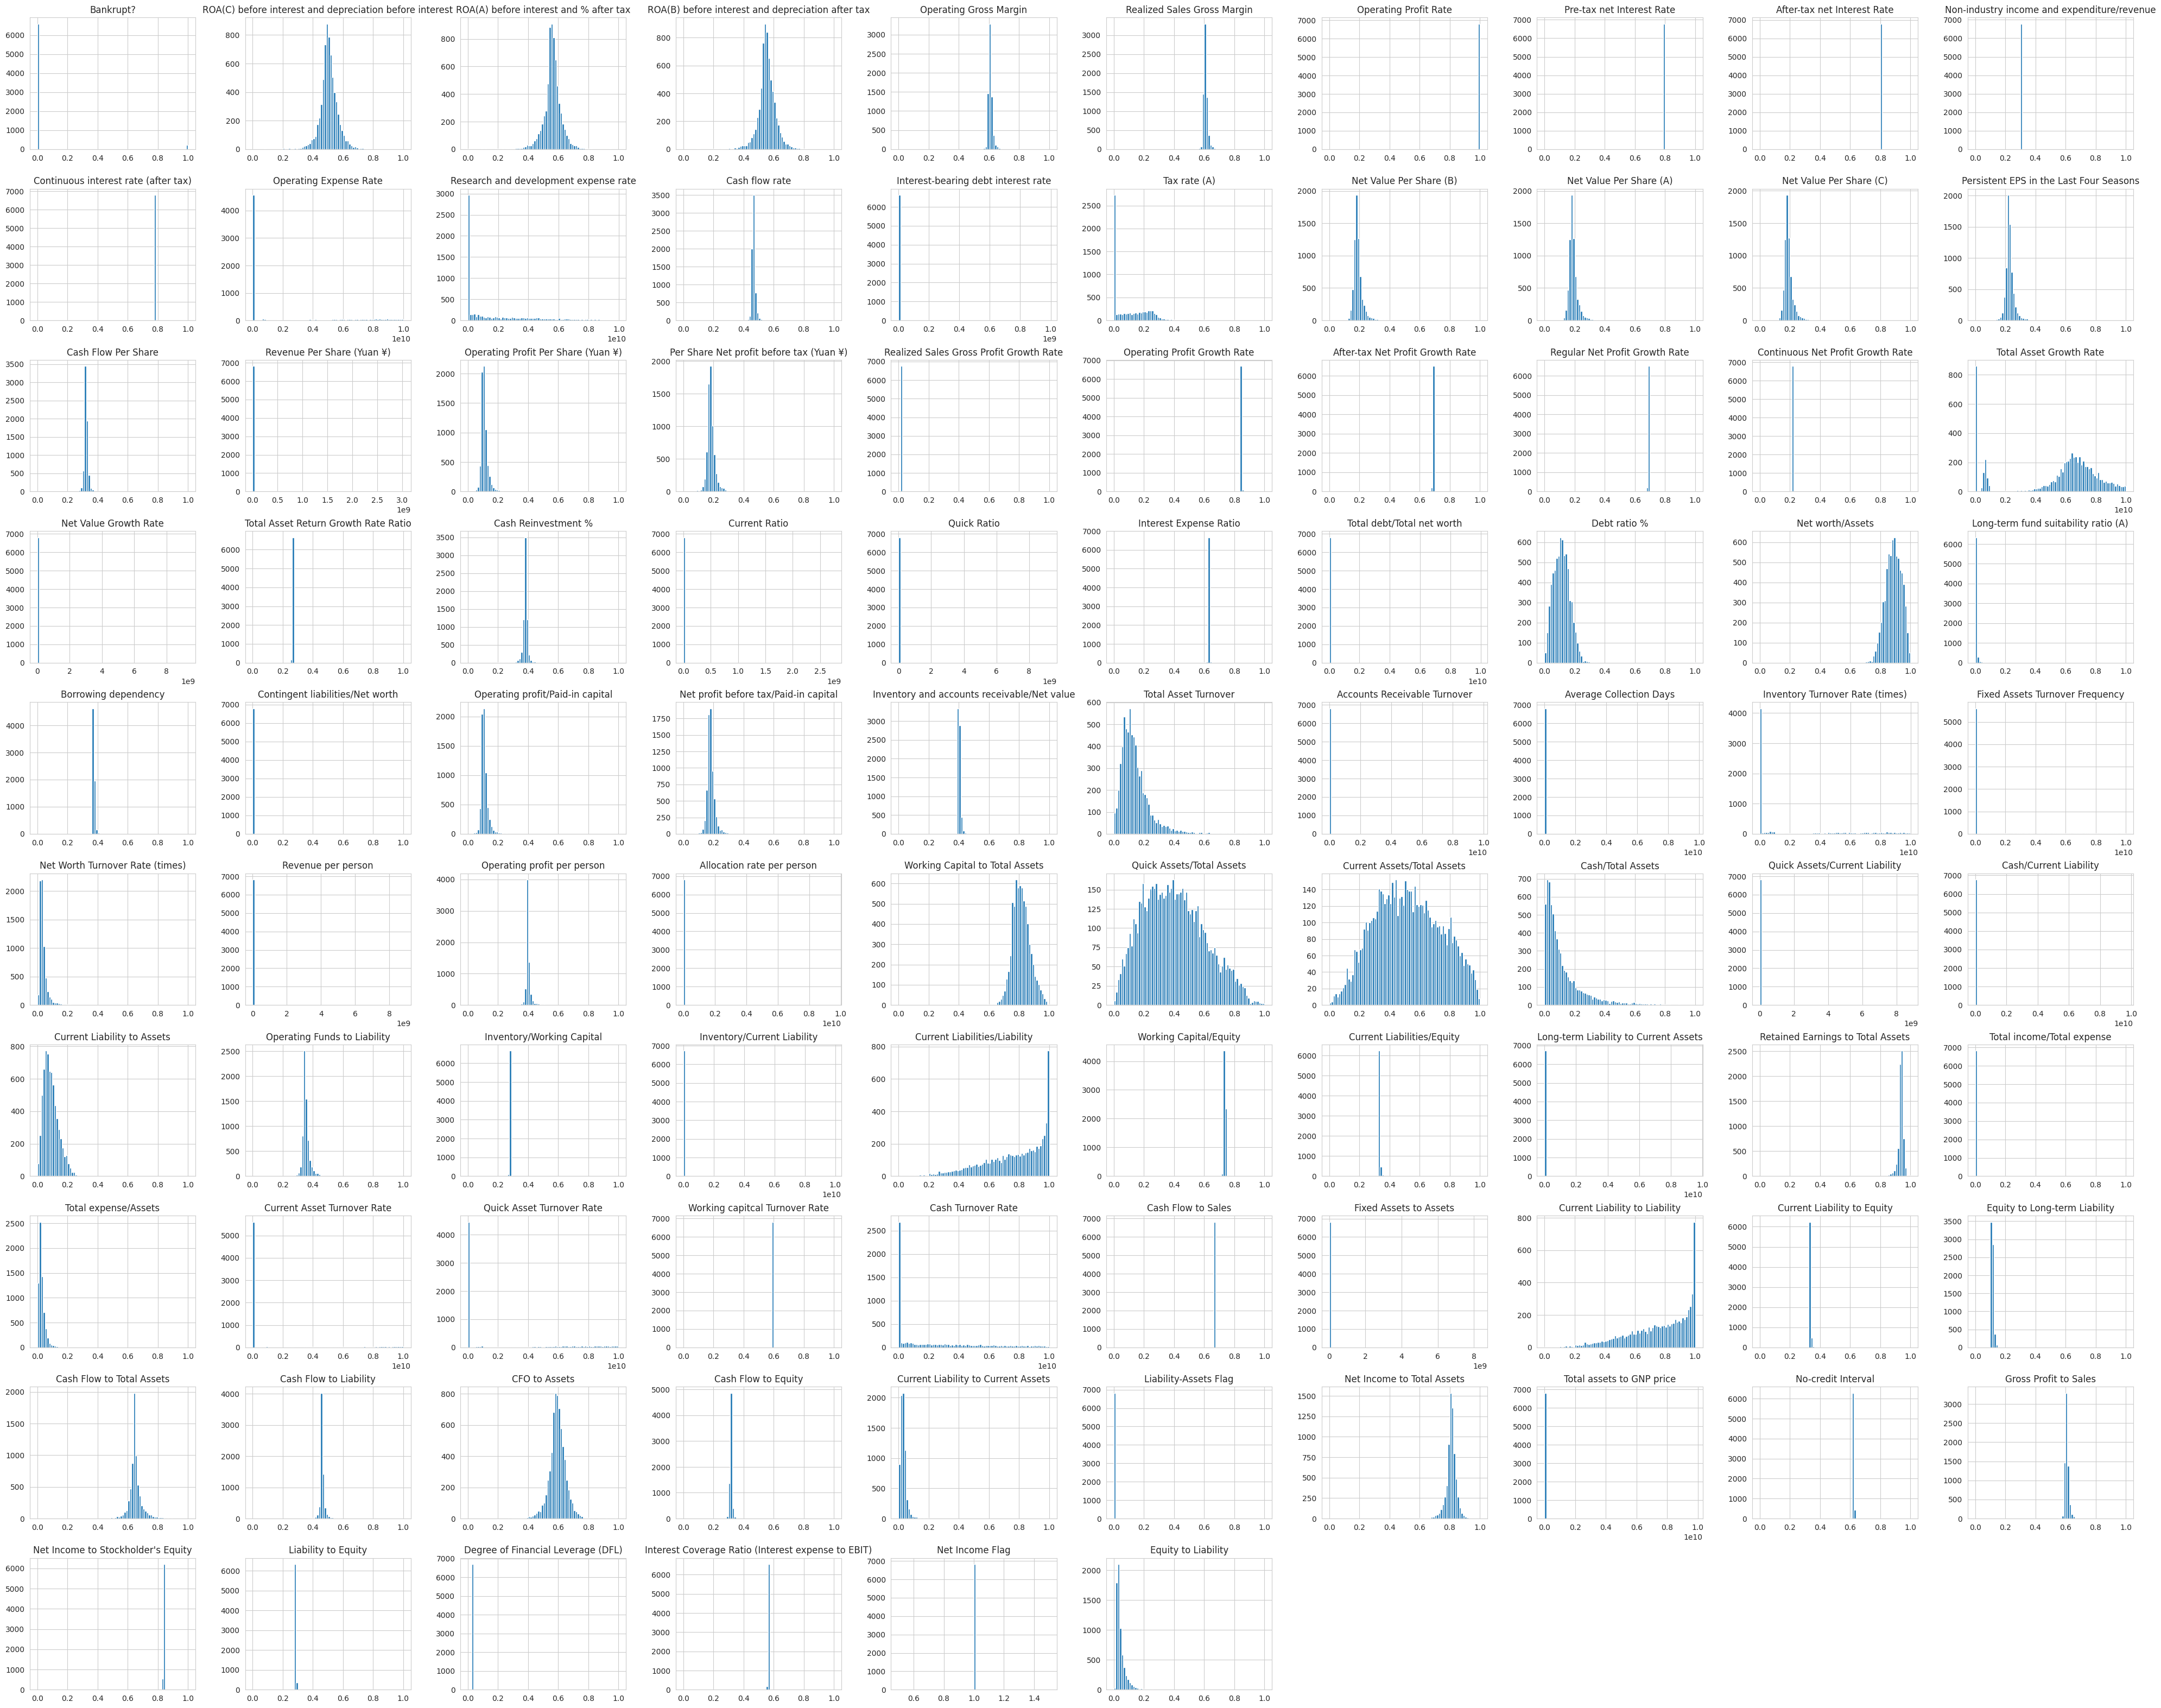

In [10]:
df.hist(figsize=(50, 40), bins=80)
plt.show()

In [11]:
cols = [(column, len(df[column].unique()) * 100 / len(df)) for column in df.columns]
for name, percent in sorted(cols, key=lambda col: col[1]):
    print(f"{name}: {percent:.3f}")

Net Income Flag: 0.015
Bankrupt?: 0.029
Liability-Assets Flag: 0.029
Total Asset Turnover: 5.587
Net Worth Turnover Rate (times): 10.867
Interest-bearing debt interest rate: 15.838
Operating Profit Per Share (Yuan ¥): 18.126
Persistent EPS in the Last Four Seasons: 19.915
Per Share Net profit before tax (Yuan ¥): 22.320
Research and development expense rate: 22.525
Cash Flow Per Share: 22.657
Accounts Receivable Turnover: 23.361
Total Asset Growth Rate: 25.678
Contingent liabilities/Net worth: 27.203
Net Value Per Share (B): 33.407
Net Value Per Share (C): 33.495
Net Value Per Share (A): 33.509
Inventory Turnover Rate (times): 35.152
Fixed Assets Turnover Frequency: 35.944
Tax rate (A): 36.486
Non-industry income and expenditure/revenue: 37.410
Total Asset Return Growth Rate Ratio: 42.572
Operating Expense Rate: 43.496
Operating profit per person: 44.332
ROA(A) before interest and % after tax: 46.209
ROA(B) before interest and depreciation after tax: 46.341
ROA(C) before interest and d

Видим, что некоторые признаки распределены на очень маленьком отрезке, однако там всё еще есть различные значения, которые могут сыграть свою роль. Посмотрим на корреляцию.

<Axes: >

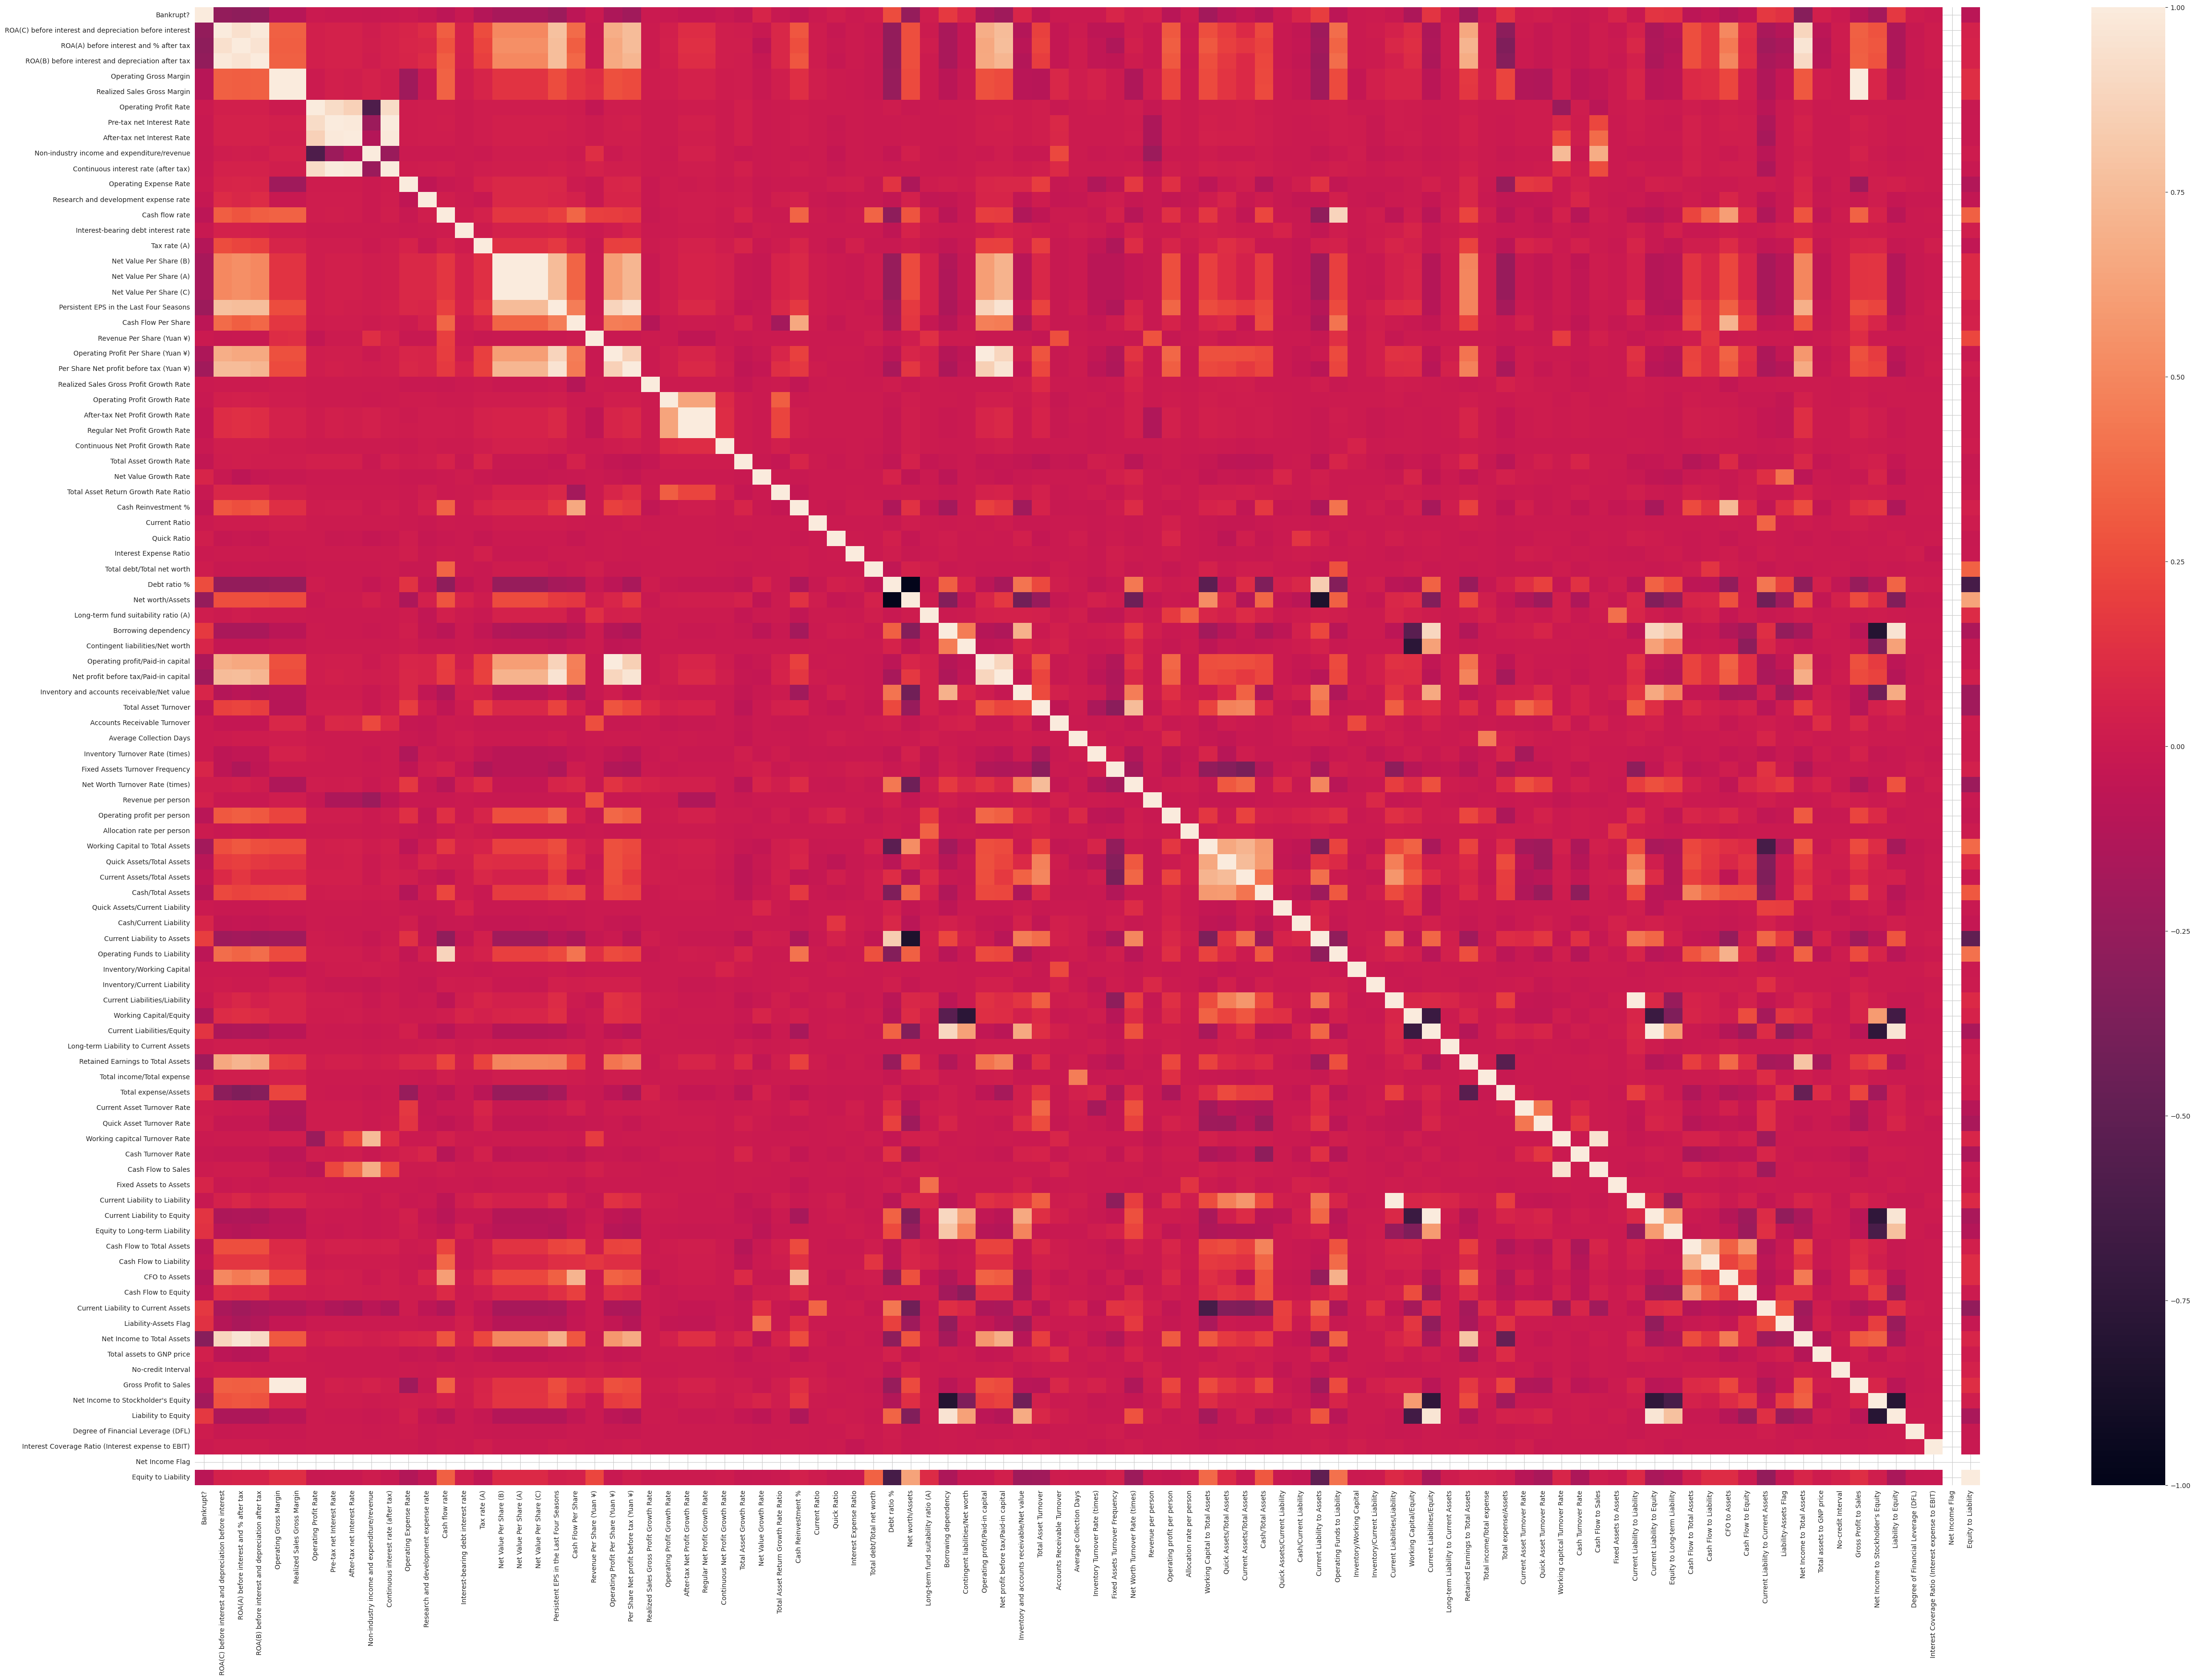

In [12]:
plt.figure(figsize=(60, 40))
sns.heatmap(df.corr())

Чтобы уменьшить количество признаков, с которыми нужно работать, уберем сильно коррелирующие признаки.

In [13]:
corr = df.corr()
threshold = 0.9
corr = corr[(corr > threshold) | (corr < -threshold)].stack().reset_index()
corr.columns = ["First feature", "Second feature", "Correlation"]
corr = corr[corr["First feature"] != corr["Second feature"]]
corr[["First feature", "Second feature"]] = np.sort(
    corr[["First feature", "Second feature"]], axis=1
)
corr = corr.drop_duplicates().reset_index(drop=True)
corr

,First feature,Second feature,Correlation
0,ROA(A) before interest and % after tax,ROA(C) before interest and depreciation before...,0.940124
1,ROA(B) before interest and depreciation after tax,ROA(C) before interest and depreciation before...,0.986849
2,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,0.955741
3,Net Income to Total Assets,ROA(A) before interest and % after tax,0.961552
4,Net Income to Total Assets,ROA(B) before interest and depreciation after tax,0.912040
5,Operating Gross Margin,Realized Sales Gross Margin,0.999518
6,Gross Profit to Sales,Operating Gross Margin,1.000000
7,Gross Profit to Sales,Realized Sales Gross Margin,0.999518
8,Operating Profit Rate,Pre-tax net Interest Rate,0.916448
9,Continuous interest rate (after tax),Operating Profit Rate,0.915544


Если приглядеться, можно заметить, что некоторые колонки значат одно и то же.

In [14]:
cols_to_delete = corr["Second feature"].values
df = df.drop(cols_to_delete, axis=1)

In [15]:
df.shape

(6819, 77)

EDA закончен, теперь преобразуем данные при помощи `StandardScaler` и разобьем на `train` и `test` для обучения моделек.

In [16]:
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]

In [17]:
X = StandardScaler().fit_transform(X)

## KMeans

In [ ]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=2, max_iter=50, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            self.labels_, _ = pairwise_distances_argmin_min(X, self.centroids)
            updated_centroids = np.array(
                [X[self.labels_ == k].mean(axis=0) for k in range(self.n_clusters)]
            )

            if np.allclose(updated_centroids, self.centroids):
                return

            self.centroids = updated_centroids

    def predict(self, X):
        self.labels_, _ = pairwise_distances_argmin_min(X, self.centroids)
        return self.labels_

В качестве количества кластеров будем использовать 2, как в оригинальном датасете.

In [19]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
)

from datetime import datetime

In [20]:
def eval(model, param_grid, X):
    grid_search = GridSearchCV(
        model,
        param_grid,
        n_jobs=4,
        scoring="adjusted_mutual_info_score",
    )
    grid_search.fit(X, y)

    model = grid_search.best_estimator_

    model.fit(X)
    labels = model.labels_
    scores = {
        "silhouette_score": silhouette_score(X, labels),
        "calinski_harabasz_score": calinski_harabasz_score(X, labels),
    }

    return model, scores

In [ ]:
def eval_pca(model, param_grid, n_comps, X_train):
    pca_scores = {}
    for n_comp in n_comps:
        X_pca = PCA(n_comp).fit_transform(X_train)

        model, pca_scores[n_comp] = eval(model, param_grid, X_pca)

    return model, pca_scores

In [22]:
n_comp = [5, 10, 30, X.shape[1]]

In [23]:
myknn_param_grid = {"max_iter": [50, 100, 200, 500, 1000]}
myknn = MyKMeans(n_clusters=2)
myknn, myknn_scores = eval_pca(myknn, myknn_param_grid, n_comp, X)

In [24]:
print(myknn_scores)

{5: {'silhouette_score': np.float64(0.24393781584571586), 'calinski_harabasz_score': np.float64(1337.8134352866787)}, 10: {'silhouette_score': np.float64(0.20612206529429178), 'calinski_harabasz_score': np.float64(898.8213230195113)}, 30: {'silhouette_score': np.float64(0.14031997198466795), 'calinski_harabasz_score': np.float64(489.2227016487578)}, 76: {'silhouette_score': np.float64(0.10678213159194157), 'calinski_harabasz_score': np.float64(348.6889382831716)}}


In [25]:
knn_param_grid = {
    "max_iter": [50, 100, 200, 500, 1000],
    "tol": [0.00001, 0.001, 0.1, 1.0],
}
knn = KMeans(n_clusters=2, init="k-means++")
knn, knn_scores = eval_pca(knn, knn_param_grid, n_comp, X)

In [26]:
print(knn_scores)

{5: {'silhouette_score': np.float64(0.19790403374380186), 'calinski_harabasz_score': np.float64(1074.858872556943)}, 10: {'silhouette_score': np.float64(0.16795867702194286), 'calinski_harabasz_score': np.float64(830.7214685909911)}, 30: {'silhouette_score': np.float64(0.13779493004670604), 'calinski_harabasz_score': np.float64(484.2265463619993)}, 76: {'silhouette_score': np.float64(0.3943529744061065), 'calinski_harabasz_score': np.float64(81.14858828841972)}}


In [ ]:
aff_param_grid = {
    "damping": [0.5, 0.9],
    "max_iter": [10, 100],
    "convergence_iter": [5, 10, 15],
}
aff = AffinityPropagation()
aff, aff_scores = eval_pca(aff, aff_param_grid, n_comp, X)

In [28]:
print(aff_scores)

{5: {'silhouette_score': np.float64(0.0714269130349761), 'calinski_harabasz_score': np.float64(478.559299052966)}, 10: {'silhouette_score': np.float64(0.09747697990906179), 'calinski_harabasz_score': np.float64(246.5410146299521)}, 30: {'silhouette_score': np.float64(0.11825615755001148), 'calinski_harabasz_score': np.float64(108.43019948974036)}, 76: {'silhouette_score': np.float64(0.03934395118123694), 'calinski_harabasz_score': np.float64(103.6837612866106)}}


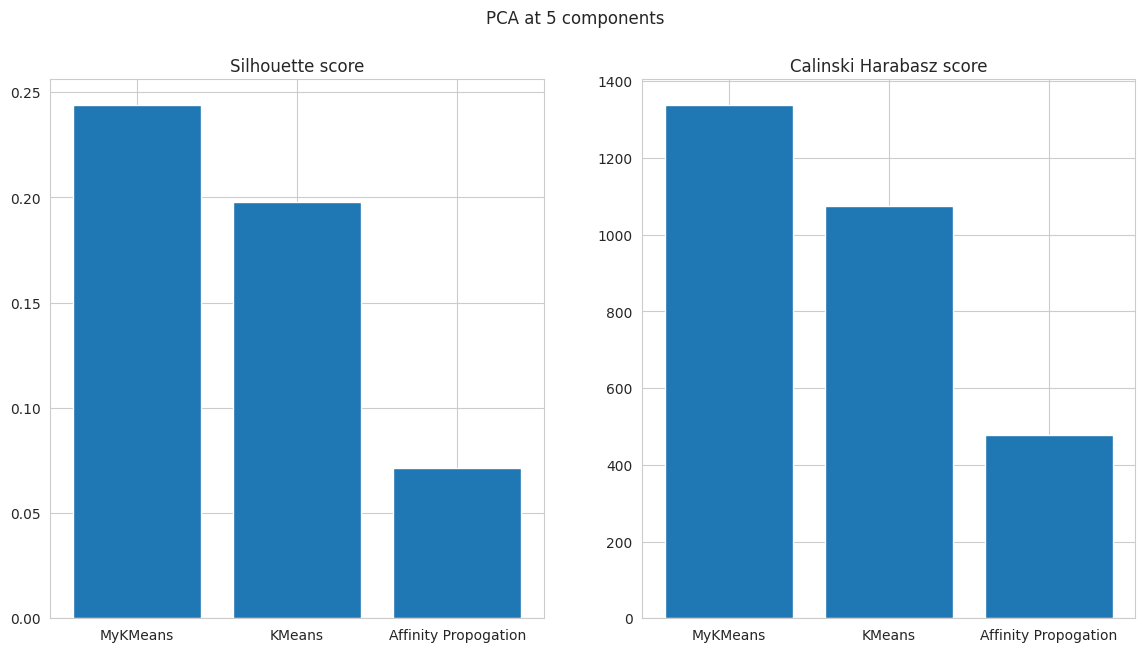

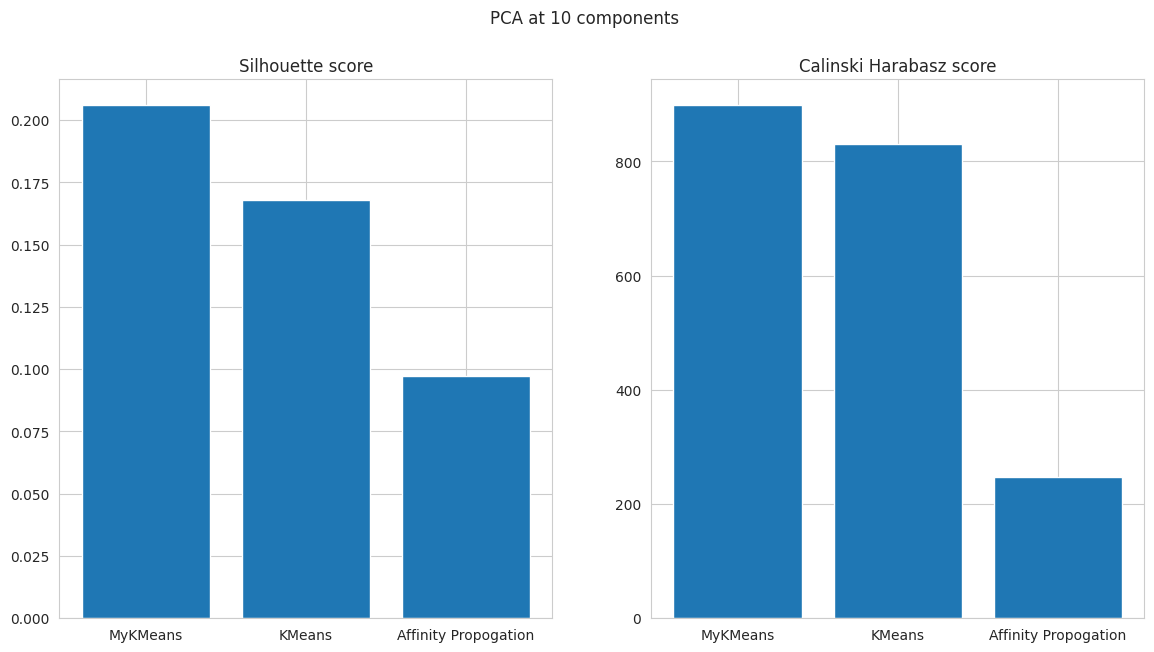

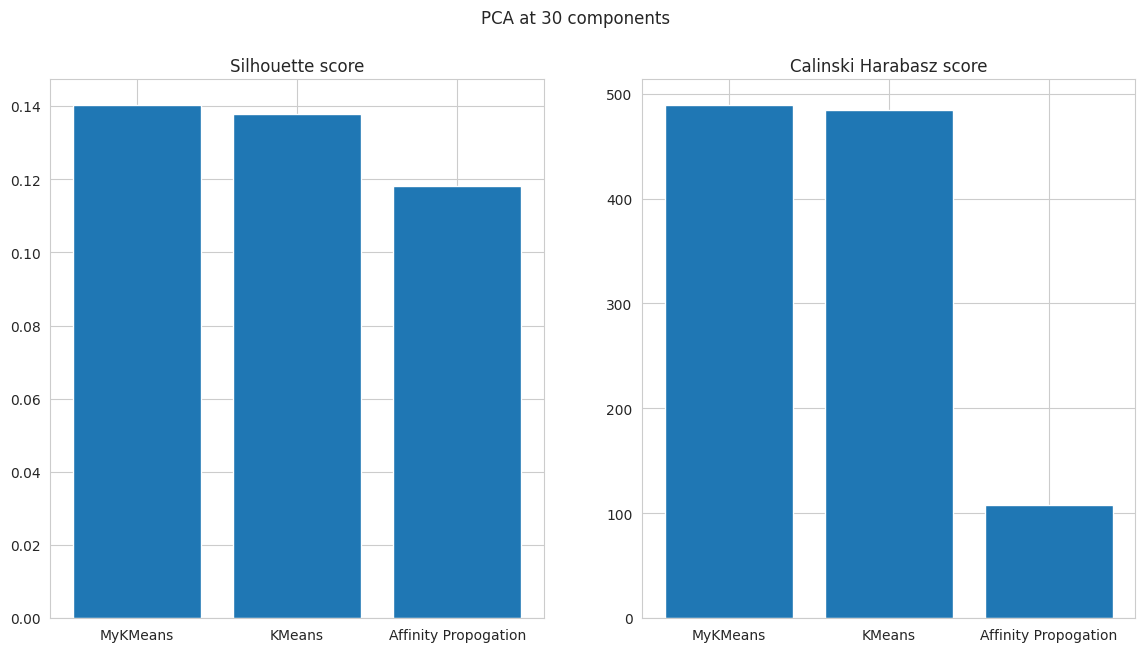

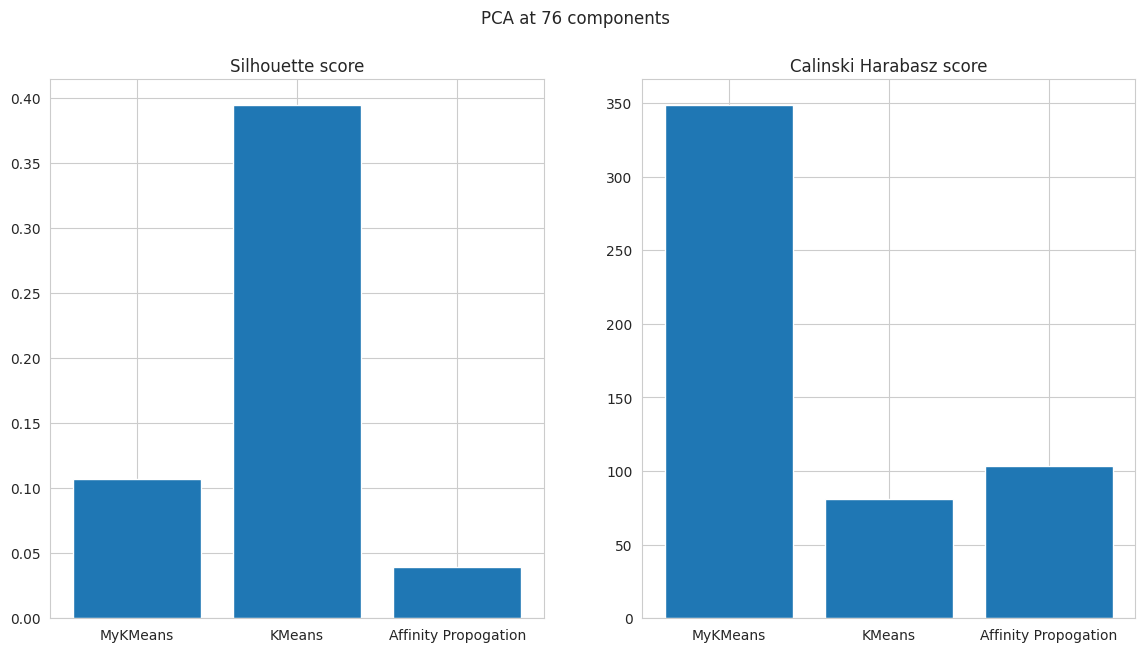

In [51]:
for comps in n_comp:
    fig, axs = plt.subplots(figsize=(14, 7), nrows=1, ncols=2)
    fig.suptitle(f"PCA at {comps} components", fontsize=12)
    axs[0].bar(
        x=["MyKMeans", "KMeans", "Affinity Propogation"],
        height=[
            myknn_scores[comps]["silhouette_score"],
            knn_scores[comps]["silhouette_score"],
            aff_scores[comps]["silhouette_score"],
        ],
    )
    axs[0].set_title("Silhouette score")
    axs[1].bar(
        x=["MyKMeans", "KMeans", "Affinity Propogation"],
        height=[
            myknn_scores[comps]["calinski_harabasz_score"],
            knn_scores[comps]["calinski_harabasz_score"],
            aff_scores[comps]["calinski_harabasz_score"],
        ],
    )
    axs[1].set_title("Calinski Harabasz score")
    plt.show()

Из графиков видно, что алгоритмы `MyKMeans` и `KMeans` в среднем работают одинаково и лучше `Affinity Propogation`. Была замечена тенденция, что при понижении количества компонентов для `PCA` метрика `Silhouette score` растет, а `Calinski Harabasz score` понижается.

## PCA и TSNE

In [ ]:
myknn.fit(X)
knn.fit(X)
aff.fit(X)

In [52]:
pca = PCA(n_components=2)

In [54]:
X_pca = pca.fit_transform(X)

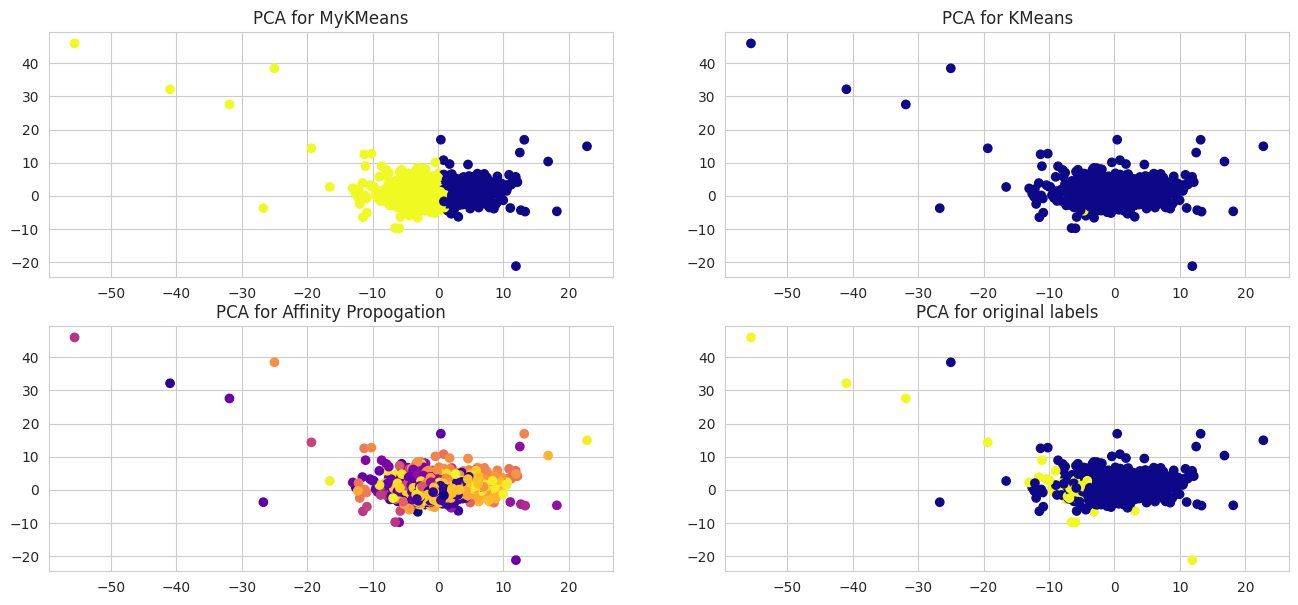

In [74]:
fig, axs = plt.subplots(figsize=(16, 7), nrows=2, ncols=2)

axs[0, 0].scatter(
    X_pca[:, 0], X_pca[:, 1], c=myknn.labels_, cmap="plasma"
)
axs[0, 0].set_title("PCA for MyKMeans")

axs[0, 1].scatter(
    X_pca[:, 0], X_pca[:, 1], c=knn.labels_, cmap="plasma"
)
axs[0, 1].set_title("PCA for KMeans")

axs[1, 0].scatter(
    X_pca[:, 0], X_pca[:, 1], c=aff.labels_, cmap="plasma"
)
axs[1, 0].set_title("PCA for Affinity Propogation")

axs[1, 1].scatter(
    X_pca[:, 0], X_pca[:, 1], c=y, cmap="plasma"
)
axs[1, 1].set_title("PCA for original labels")

plt.show()

In [75]:
tsne = TSNE()

In [76]:
X_tsne = tsne.fit_transform(X)

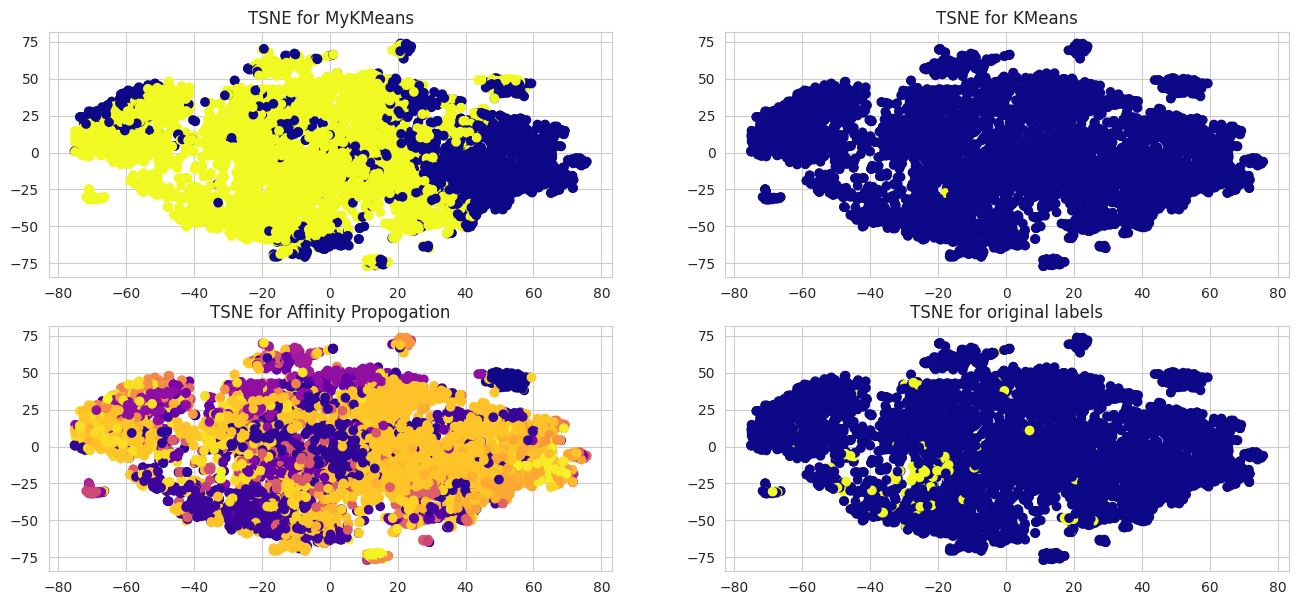

In [77]:
fig, axs = plt.subplots(figsize=(16, 7), nrows=2, ncols=2)

axs[0, 0].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=myknn.labels_, cmap="plasma"
)
axs[0, 0].set_title("TSNE for MyKMeans")

axs[0, 1].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=knn.labels_, cmap="plasma"
)
axs[0, 1].set_title("TSNE for KMeans")

axs[1, 0].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=aff.labels_, cmap="plasma"
)
axs[1, 0].set_title("TSNE for Affinity Propogation")

axs[1, 1].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="plasma"
)
axs[1, 1].set_title("TSNE for original labels")

plt.show()

Алгоритм `Affinity Propogation` нашел гораздо больше кластеров, чем представленные два. Алгоритм `MyKMeans` разделил выборку на два четких почти равных класса (как видно на `PCA`), хотя, если посмотреть на оригинальное распределение, виден яркий дисбаланс этих классов. Таким образом, `KMeans`, определивший подавляющее большинство объектов к одному кластеру, справился с задачей кластеризации лучше всего.